<center>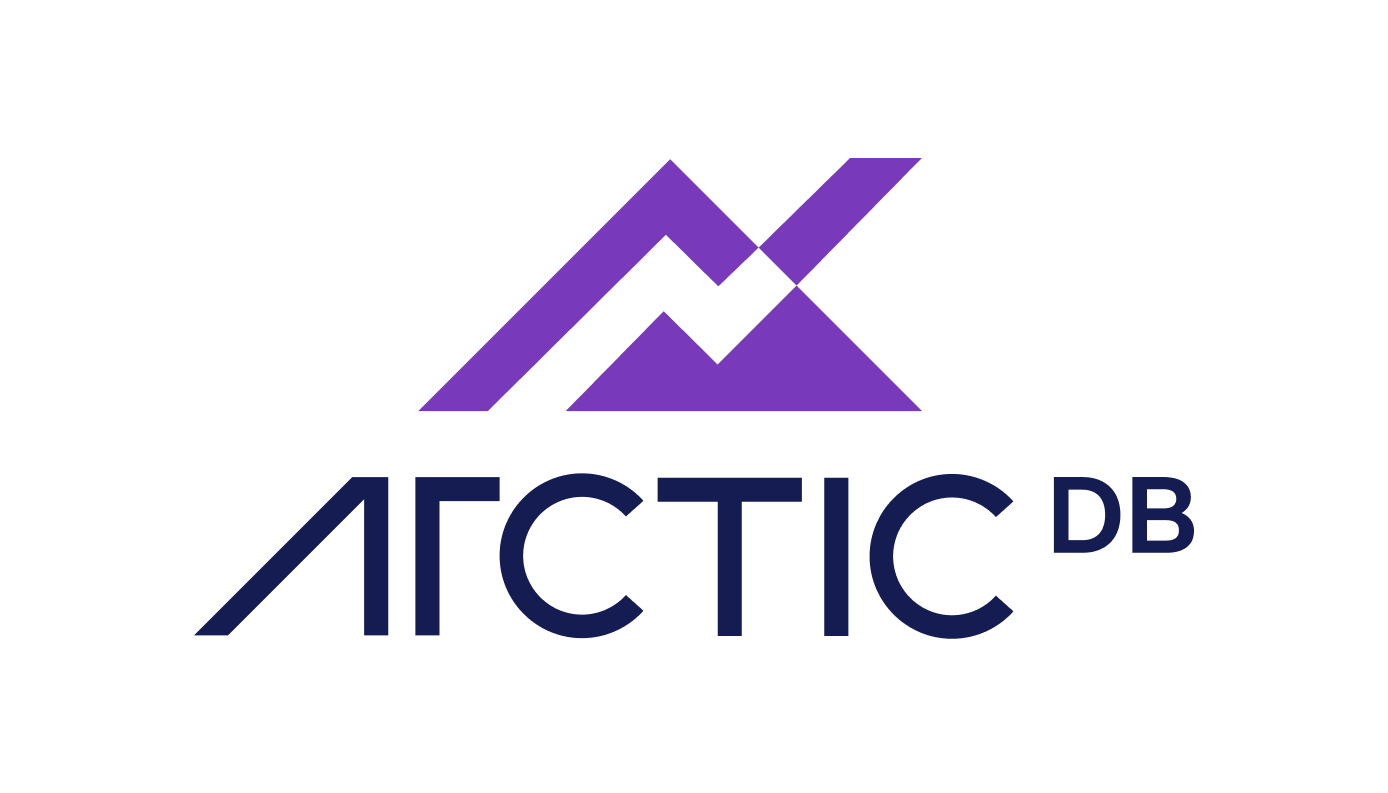
</center>

# ArcticDB Resample Demo

This demo notebook showcases the high-performance resample capability of ArcticDB.

This is what you need to know about it:

* It runs on-the-fly as part of the read
* This makes it much more efficient than Pandas on large datasets
* The usage is similar to the Pandas resample function
* You can apply multiple aggregators to each column
* It can be used for downsampling high frequency data and generating "bar" data (see example 4)

## Setup

In [ ]:
!pip install arcticdb

In [2]:
import numpy as np
import pandas as pd
import arcticdb as adb

In [3]:
# object store
arctic = adb.Arctic("lmdb://arcticdb_resample")

In [4]:
# library
lib = arctic.get_library('resample', create_if_missing=True)

## Create Some Data

* timeseries with 12,000,000 rows and a 1-second index
* int, float, string columns
* write the data into ArcticDB

In [5]:
# data for resampling
index = pd.date_range("1990-01-01", periods=12_000_000, freq="s")
int_data = np.arange(len(index), dtype=np.uint64)
float_data = np.round(np.random.uniform(95., 105., len(index)), 3)
letters = ['a','b','c','d','e','f','g']
mkt_data = pd.DataFrame(
    index=index,
    data={
        "id": int_data,
        "price": float_data,
        "category": (letters*(len(index)//len(letters) + 1))[:len(index)]
    }
)

In [6]:
# view the first 10 rows of the data
mkt_data.head(10)

,id,price,category
1990-01-01 00:00:00,0,95.176,a
1990-01-01 00:00:01,1,97.872,b
1990-01-01 00:00:02,2,104.930,c
1990-01-01 00:00:03,3,103.573,d
1990-01-01 00:00:04,4,97.052,e
1990-01-01 00:00:05,5,103.435,f
1990-01-01 00:00:06,6,99.339,g
1990-01-01 00:00:07,7,103.358,a
1990-01-01 00:00:08,8,104.301,b
1990-01-01 00:00:09,9,104.651,c


In [7]:
# write the data into ArcticDB
sym = 'market_data'
lib.write(sym, mkt_data)

VersionedItem(symbol='market_data', library='resample', data=n/a, version=0, metadata=None, host='LMDB(path=~/arcticdb_resample)', timestamp=1718958796318913629)

## 1. Simple Resample

* Resample to 1-minute
* Use different aggregators
* Resample can be thought of as a time-based groupby
* The groups are all the rows within a time interval
* Run also in Pandas to compare performance and results 

In [8]:
# frequency and aggregator params
freq1 = '1min'
aggs1 = {'id': 'max', 'price': 'last', 'category': 'count'}

In [9]:
%%time
# create the resample query and apply it on the read
market_data_1min_df = lib.read(sym, lazy=True).resample(freq1).agg(aggs1).collect().data
print(len(market_data_1min_df))
market_data_1min_df.tail()

200000
CPU times: user 684 ms, sys: 251 ms, total: 935 ms
Wall time: 171 ms


,id,price,category
1990-05-19 21:15:00,11999759,104.106,60
1990-05-19 21:16:00,11999819,104.456,60
1990-05-19 21:17:00,11999879,95.570,60
1990-05-19 21:18:00,11999939,103.967,60
1990-05-19 21:19:00,11999999,97.899,60


In [10]:
%%time
# read the full data set and resample in Pandas
full_df = lib.read(sym).data
market_data_1min_pd_df = full_df.resample(freq1).agg(aggs1)
print(len(market_data_1min_pd_df))
market_data_1min_pd_df.tail()

200000
CPU times: user 1.6 s, sys: 401 ms, total: 2 s
Wall time: 1.15 s


,id,price,category
1990-05-19 21:15:00,11999759,104.106,60
1990-05-19 21:16:00,11999819,104.456,60
1990-05-19 21:17:00,11999879,95.570,60
1990-05-19 21:18:00,11999939,103.967,60
1990-05-19 21:19:00,11999999,97.899,60


## 2. Multiple Aggregators per Column

* Similar to NamedAgg in Pandas
* Downsample to 5-minute frequency
* Apply both max and last aggregators to the price column
* For multiple aggregators, the syntax is `output_column_name: (input_column_name: aggregator)`

In [11]:
freq2 = '5min'
aggs2 = {'id': 'max', 'price_last': ('price' ,'last'), 'price_count': ('price' ,'count'), 'category': 'first'}

In [12]:
%%time
lib.read(sym, lazy=True).resample(freq2).agg(aggs2).collect().data

CPU times: user 1.07 s, sys: 415 ms, total: 1.49 s
Wall time: 151 ms


,id,category,price_count,price_last
1990-01-01 00:00:00,299,a,300,102.172
1990-01-01 00:05:00,599,g,300,101.450
1990-01-01 00:10:00,899,f,300,96.718
1990-01-01 00:15:00,1199,e,300,96.345
1990-01-01 00:20:00,1499,d,300,98.955
...,...,...,...,...
1990-05-19 20:55:00,11998799,d,300,100.277
1990-05-19 21:00:00,11999099,c,300,103.596
1990-05-19 21:05:00,11999399,b,300,96.182
1990-05-19 21:10:00,11999699,a,300,99.911


## 3. Processing Pipeline: Chaining Operations

* Downsample to 2.5-minutes frequency
* Group the resampled data by the category column
* Aggregate the category groups using mean

In [14]:
%%time
lib.read(sym, lazy=True).resample('2min30s').agg({'id': 'min', 'category': 'first'}).groupby('category').agg({'id': 'mean'}).collect().data

CPU times: user 1.12 s, sys: 309 ms, total: 1.43 s
Wall time: 183 ms


,id
category,
a,5999700.0
b,5999925.0
d,5999850.0
e,6000075.0
f,5999775.0
g,6000000.0
c,6000150.0


## 4. Example: OHLC (Open High Low Close) Bars

* Downsample to 5-minute frequency
* Use multiple aggregators on the price column
* This is a simple example of how to convert tick data to OHLC bar data

In [15]:
freq_ohlc = '5min'
agg_ohlc = {
    'open': ('price', 'first'),
    'high': ('price', 'max'),
    'low': ('price', 'min'),
    'close': ('price', 'last')
}

In [16]:
%%time
ohlc_5min_bars = lib.read(sym, lazy=True).resample(freq_ohlc).agg(agg_ohlc).collect().data

CPU times: user 1.26 s, sys: 492 ms, total: 1.75 s
Wall time: 118 ms


In [17]:
ohlc_5min_bars.head()

,close,low,high,open
1990-01-01 00:00:00,102.172,95.076,104.992,95.176
1990-01-01 00:05:00,101.450,95.008,104.999,98.520
1990-01-01 00:10:00,96.718,95.053,104.990,103.959
1990-01-01 00:15:00,96.345,95.070,104.969,95.878
1990-01-01 00:20:00,98.955,95.011,104.983,103.538


## Conclusion

We have demonstrated the following about the ArcticDB resample feature:

* Easy to use, especially if you already resample in Pandas
* Very high performance - in particular much faster than reading all the data then resampling in Pandas
* Can be combined with other query functions to build processing pipelines
* Can be used to generate timeseries bars